**Baseline Modeling**
- 

This notebook establishes a baseline for predicting NFL fantasy points by implementing regression models to analyze player performance. The goal is to build a foundation for more advanced modeling by exploring key predictors and assessing their impact on prediction accuracy. We will begin by preprocessing, then further exploratory data analysis, building and fitting ridge regression models, and then analyzing model performance metrics.

**Objectives**
- Capture recent player trends using feature engineering for key stats such as passing yards, rushing yards, and receiving yards
- Calculate cumulative and average season metrics (e.g., total and average fantasy points) up to each week, excluding the current week, to provide a comprehensive view of player performance
- Implement and evaluate baseline regression models to predict fantasy performance across each position (e.g., QB, RB, WR, TE)

**Evaluation Metrics**

- Mean Absolute Error (MAE): To measure the average prediction error.
- R-squared: To evaluate how well the model explains variance in fantasy points.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

Importing libraries/packages

In [2]:
dfAll = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/Dataframes/dfAll.csv")
qbs = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/Dataframes/qbs.csv")
rbs = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/Dataframes/rbs.csv")
wrs = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/Dataframes/wrs.csv")
tes = pd.read_csv("/Users/mychalortiz/Downloads/Brainstation/FantasyForecasts/notebooks/Dataframes/tes.csv")

Transferring dataframes from previous notebook to the current notebook

In [3]:
qbs.head(5)

,Unnamed: 0,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,PROJ,PASSING YDS,PASSING TD,PASSING INT,RUSHING CAR,...,PASSING COMPLETION,PASSING ATTEMPTS,Opponent,Location,rank,DATE,Week,Free_Agent,did_not_play,Win_Loss
0,2,Josh Allen,Buf,QB,W 48-20,20.9,320.0,4.0,0.0,4.0,...,21.0,25.0,Mia,Home,1.0,10-03-23,4,False,0,1
1,7,Anthony Richardson,Ind,QB,L 23-29,20.2,200.0,2.0,0.0,10.0,...,11.0,25.0,LAR,Home,2.0,10-03-23,4,False,0,0
2,8,Lamar Jackson,Bal,QB,W 28-3,17.9,186.0,2.0,0.0,9.0,...,15.0,19.0,Cle,Away,3.0,10-03-23,4,False,0,1
3,10,Justin Fields,Chi,QB,L 28-31,20.0,335.0,4.0,1.0,4.0,...,28.0,35.0,Den,Home,4.0,10-03-23,4,False,0,0
4,20,Jalen Hurts,Phi,QB,W 34-31,21.7,319.0,2.0,0.0,9.0,...,25.0,37.0,Wsh,Home,5.0,10-03-23,4,False,0,1


Ensuring dataframes have been transfered

**Pre-Processing (Continued)**
- 

In [6]:
label_encoder = LabelEncoder()
#creating label encoder

dfList = {'qbs': qbs, 'rbs': rbs, 'wrs': wrs, 'tes': tes}
#creating list of fataframes

dfCopies = {}
#creating dictionary to hold copies of modified DataFrames

for name, df in dfList.items():
    df_copy = df.copy()
    #creating a copy of the dataframe
    df_copy['Name_Encoded'] = label_encoder.fit_transform(df['PLAYER NAME'])
    df_copy['Team_Encoded'] = label_encoder.fit_transform(df['PLAYER TEAM'])
    df_copy['Opponent_Encoded'] = label_encoder.fit_transform(df['Opponent'])
    df_copy['Home/Away_Encoded'] = label_encoder.fit_transform(df['Location'])
    #adding the encoded columns to the new dataframe
    globals()[f"{name}M"] = df_copy
    #creating a new dataframe for each DataFrame copy

wrs.head(3)
#looking into 'wrsM' to make sure this process was completed succesfully

,Unnamed: 0,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,PROJ,PASSING YDS,PASSING TD,PASSING INT,RUSHING CAR,...,PASSING COMPLETION,PASSING ATTEMPTS,Opponent,Location,rank,DATE,Week,Free_Agent,did_not_play,Win_Loss
0,1,A.J. Brown,Phi,WR,W 34-31,15.7,0.0,0.0,0.0,0.0,...,0.0,0.0,Wsh,Home,1.0,10-03-23,4,False,0,1
1,3,Stefon Diggs,Buf,WR,W 48-20,17.8,0.0,0.0,0.0,0.0,...,0.0,0.0,Mia,Home,2.0,10-03-23,4,False,0,1
2,4,Nico Collins,Hou,WR,W 30-6,12.2,0.0,0.0,0.0,0.0,...,0.0,0.0,Pit,Home,3.0,10-03-23,4,False,0,1


- Looping through a list of each dataframe and creating a copy, then adding encodod columns
- Encoding name, team, opponent, and location for each dataframe
- Made this slightly more complicated than it needed to be, but code was already written for several models using '{position df}M', and felt this would be easier than editing each line of code
    - Came back and changed the previous code to include a for loop in order to be more efficient

In [ ]:
qbs.head(5)

In [8]:
JA = qbsM[qbsM['PLAYER NAME'] == 'Josh Allen']
#creating df to view rows where 'PLAYER NAME' = 'Josh Allen'
JA.head(5)

,Unnamed: 0,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,PROJ,PASSING YDS,PASSING TD,PASSING INT,RUSHING CAR,...,rank,DATE,Week,Free_Agent,did_not_play,Win_Loss,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded
0,2,Josh Allen,Buf,QB,W 48-20,20.9,320.0,4.0,0.0,4.0,...,1.0,10-03-23,4,False,0,1,41,3,19,1
64,1111,Josh Allen,Buf,QB,L 16-22,21.1,236.0,1.0,3.0,6.0,...,23.0,09-12-23,1,False,0,0,41,3,24,0
89,2034,Josh Allen,Buf,QB,W 37-3,20.8,218.0,1.0,1.0,3.0,...,8.0,09-26-23,3,False,0,1,41,3,31,0
125,3022,Josh Allen,Buf,QB,L 20-25,20.7,359.0,2.0,1.0,4.0,...,2.0,10-10-23,5,False,0,0,41,3,14,1
166,4034,Josh Allen,Buf,QB,W 32-6,18.9,275.0,3.0,1.0,5.0,...,6.0,11-21-23,11,False,0,1,41,3,24,1


- Creating a dataframe to view rows where the player is Josh Allen to ensure the label encoding has ran smoothly

In [107]:
dfMList = {'qbsM': qbsM, 'rbsM': rbsM, 'wrsM': wrsM, 'tesM': tesM}
#creating a dictionary that maps names to dataframes

for name, dfM in dfMList.items():
    dfM = dfM.sort_values(['PLAYER NAME', 'DATE'])

    for col in ['TOTAL', 'PASSING YDS', 'PASSING TD', 'RECEIVING REC', 
                'RECEIVING YDS', 'RECEIVING TD', 'RUSHING CAR', 'RUSHING YDS', 'RUSHING TD']:
        if col in dfM.columns: 
            new_col = col.lower().replace(' ', '_') + '_5_game_avg'
            dfM[new_col] = dfM.groupby('PLAYER NAME')[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    #calculating 5-game rolling averages for fantasy points and other stats

    for col in ['TOTAL', 'PASSING YDS', 'PASSING TD', 'RECEIVING REC', 
                'RECEIVING YDS', 'RECEIVING TD', 'RUSHING CAR', 'RUSHING YDS', 'RUSHING TD']:
        if col in dfM.columns:
            new_col = 'season_' + col.lower().replace(' ', '_')
            dfM[new_col] = dfM.groupby('PLAYER NAME')[col].cumsum()
    #calculating cumulative stats

    for col in ['season_total', 'season_passing_yds', 'season_passing_td', 
                'season_receiving_rec', 'season_receiving_yds', 'season_receiving_td',
                'season_rushing_car', 'season_rushing_yds', 'season_rushing_tds']:
        if col in dfM.columns:
            avg_col = col + '_avg'
            dfM[avg_col] = dfM[col] / (dfM.groupby('PLAYER NAME').cumcount() + 1)
    #calculating cumulative averages

    if 'season_total' in dfM.columns:
        dfM['season_fantasy_points_avg'] = dfM['season_total'] / (dfM.groupby('PLAYER NAME').cumcount() + 1)
    #ensure cumulative averages are recalculated correctly

    dfM.drop(columns=['Unnamed: 0', 'PROJ', 'PASSING YDS', 'PASSING TD', 'RUSHING CAR', 'PASSING INT', 'RUSHING YDS',
                      'RUSHING TD', 'RECEIVING REC', 'RECEIVING YDS', 'RECEIVING TD', 'RECEIVING TAR',
                      'MISC 2PC', 'MISC FUML', 'MISC TD', 'PASSING COMPLETION', 'PASSING ATTEMPTS', 'Win_Loss'], inplace=True, errors='ignore')
    #dropping unnecessary columns
    
    dfMList[name] = dfM
    #ensuring that the updated dataframe is saved back to the dictionary

qbsM = dfMList['qbsM']
rbsM = dfMList['rbsM']
wrsM = dfMList['wrsM']
tesM = dfMList['tesM']
#reassigning dataframes to standalone variables

- Looping through the position modeling dataframes and creating new features based on historical data
- Creating features such as 5-game rolling averages and season cumulative averages up to the current date
- Doing this in order to give the models more data that can help improve their predictive power and accuracy
- Removed the current weeks statistics
    - In order to predict the fantasy points for a certain week, the model can not have access to that weeks statistics
    - By removing this data, the model relies on only historical data in order to make predictions, as would be the case in a real world scenario where future performance is unknown

In [64]:
qbsM.head(5)

,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,TOTAL,Opponent,Location,rank,DATE,Week,...,season_rushing_tds,season_fantasy_points_avg,season_passing_yards_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yards_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_rushing_tds_avg
335,AJ McCarron,Cin,QB,W 31-14,0.80,Cle,Home,34.0,01-09-24,18,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,AJ McCarron,Cin,QB,W 34-14,-0.04,Ind,Home,38.0,12-12-23,14,...,0.0,0.40,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,Aaron Rodgers,NYJ,QB,W 22-16,0.00,Buf,Home,36.0,09-12-23,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468,Aidan O'Connell,LV,QB,L 20-23,20.26,Ind,Away,9.0,01-02-24,17,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,Aidan O'Connell,LV,QB,W 27-14,17.86,Den,Home,11.0,01-09-24,18,...,0.0,10.13,149.5,1.0,0.0,0.0,0.0,1.0,1.5,0.0


- Ensuring that the changes have been made to the dataframes

**Exploratory Data Analysis (Continued)**
- 
Continuing exploratory data analysis after preprocessing, as this step has made significant changes in the dataframe

In [83]:
for name, dfM in dfList.items():
    print(dfM.isnull().sum())

Unnamed: 0            0
PLAYER NAME           0
PLAYER TEAM           0
PLAYER POSITION       0
STATUS                0
PROJ                  0
PASSING YDS           0
PASSING TD            0
PASSING INT           0
RUSHING CAR           0
RUSHING YDS           0
RUSHING TD            0
RECEIVING REC         0
RECEIVING YDS         0
RECEIVING TD          0
RECEIVING TAR         0
MISC 2PC              0
MISC FUML             0
MISC TD               0
TOTAL                 0
PASSING COMPLETION    0
PASSING ATTEMPTS      0
Opponent              0
Location              0
rank                  0
DATE                  0
Week                  0
Free_Agent            0
did_not_play          0
Win_Loss              0
dtype: int64
Unnamed: 0            0
PLAYER NAME           0
PLAYER TEAM           0
PLAYER POSITION       0
STATUS                0
PROJ                  0
PASSING YDS           0
PASSING TD            0
PASSING INT           0
RUSHING CAR           0
RUSHING YDS           0
RUS

- Using for loop to iterate through dataframes and check for nulls
- No nulls found

In [82]:
for name, dfM in dfList.items():
    print(dfM.duplicated().sum())

0
0
0
0


- Using for loop to iterate through dataframes and check for duplicates
- No duplicates found

**Plotting Average Fantasy Points by Week**

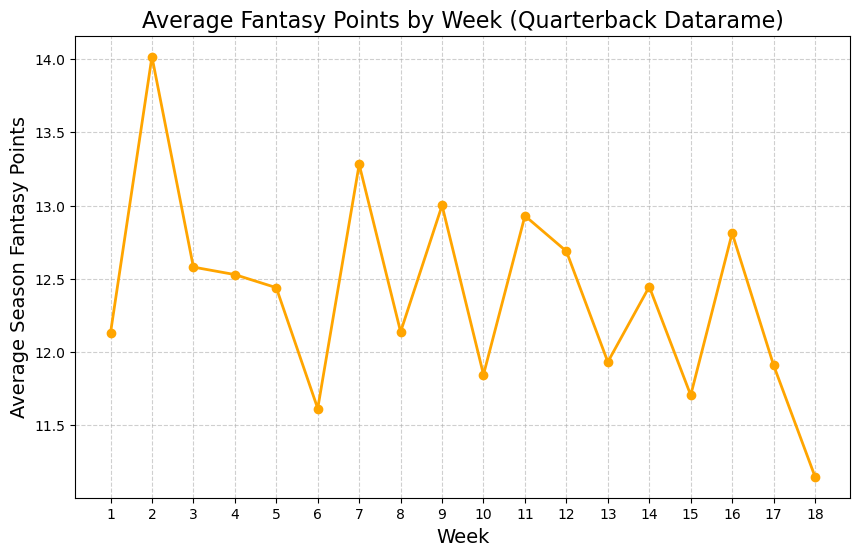

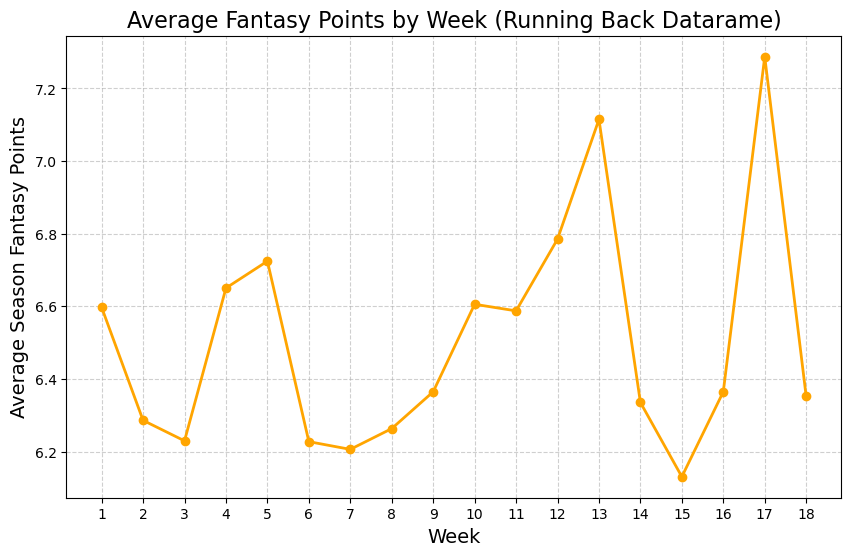

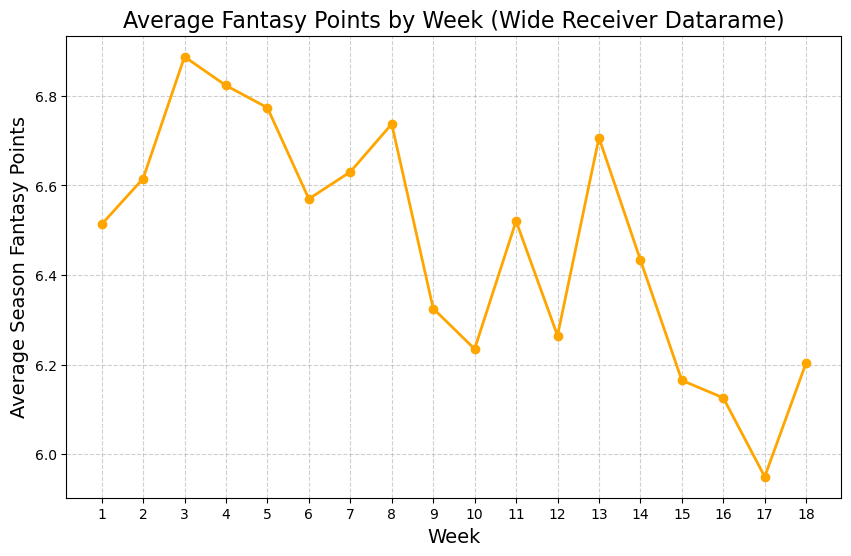

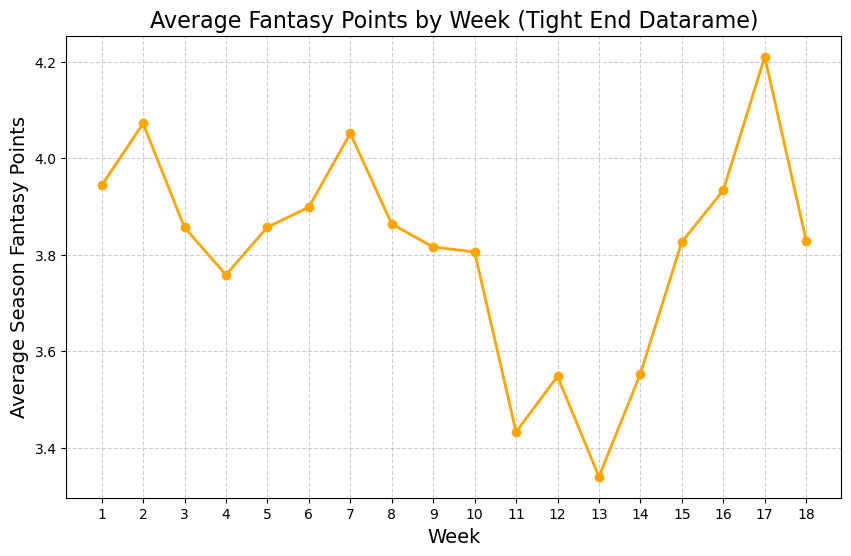

In [112]:
dfMList = { 'qbsM': qbsM, 'rbsM': rbsM, 'wrsM': wrsM, 'tesM': tesM}
#creating a dictionary that maps names to dataframes

dfNames = ['Quarterback', 'Running Back', 'Wide Receiver', 'Tight End']
#creating list for position names
#doing this allows me to use the position name for the title of each heatmap
#using 'name' within dfList would display 'qbsM dataframe'

for i, (name, dfM) in enumerate(dfMList.items()):
    average_points_by_week = dfM.groupby('Week')['season_fantasy_points_avg'].mean()
    #grouping by 'week' to calculate the average season_fantasy_points_avg

    plt.figure(figsize=(10, 6))
    plt.plot(average_points_by_week.index, average_points_by_week.values, marker='o', linestyle='-', linewidth=2, color='orange')
    plt.title(f'Average Fantasy Points by Week ({dfNames[i]} Datarame)', fontsize=16)
    plt.xlabel('Week', fontsize=14)
    plt.ylabel('Average Season Fantasy Points', fontsize=14)
    plt.xticks(range(1, len(average_points_by_week) + 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    #plotting

- Plotting the average fantasy points by week for each position

**Correlation Matrices**

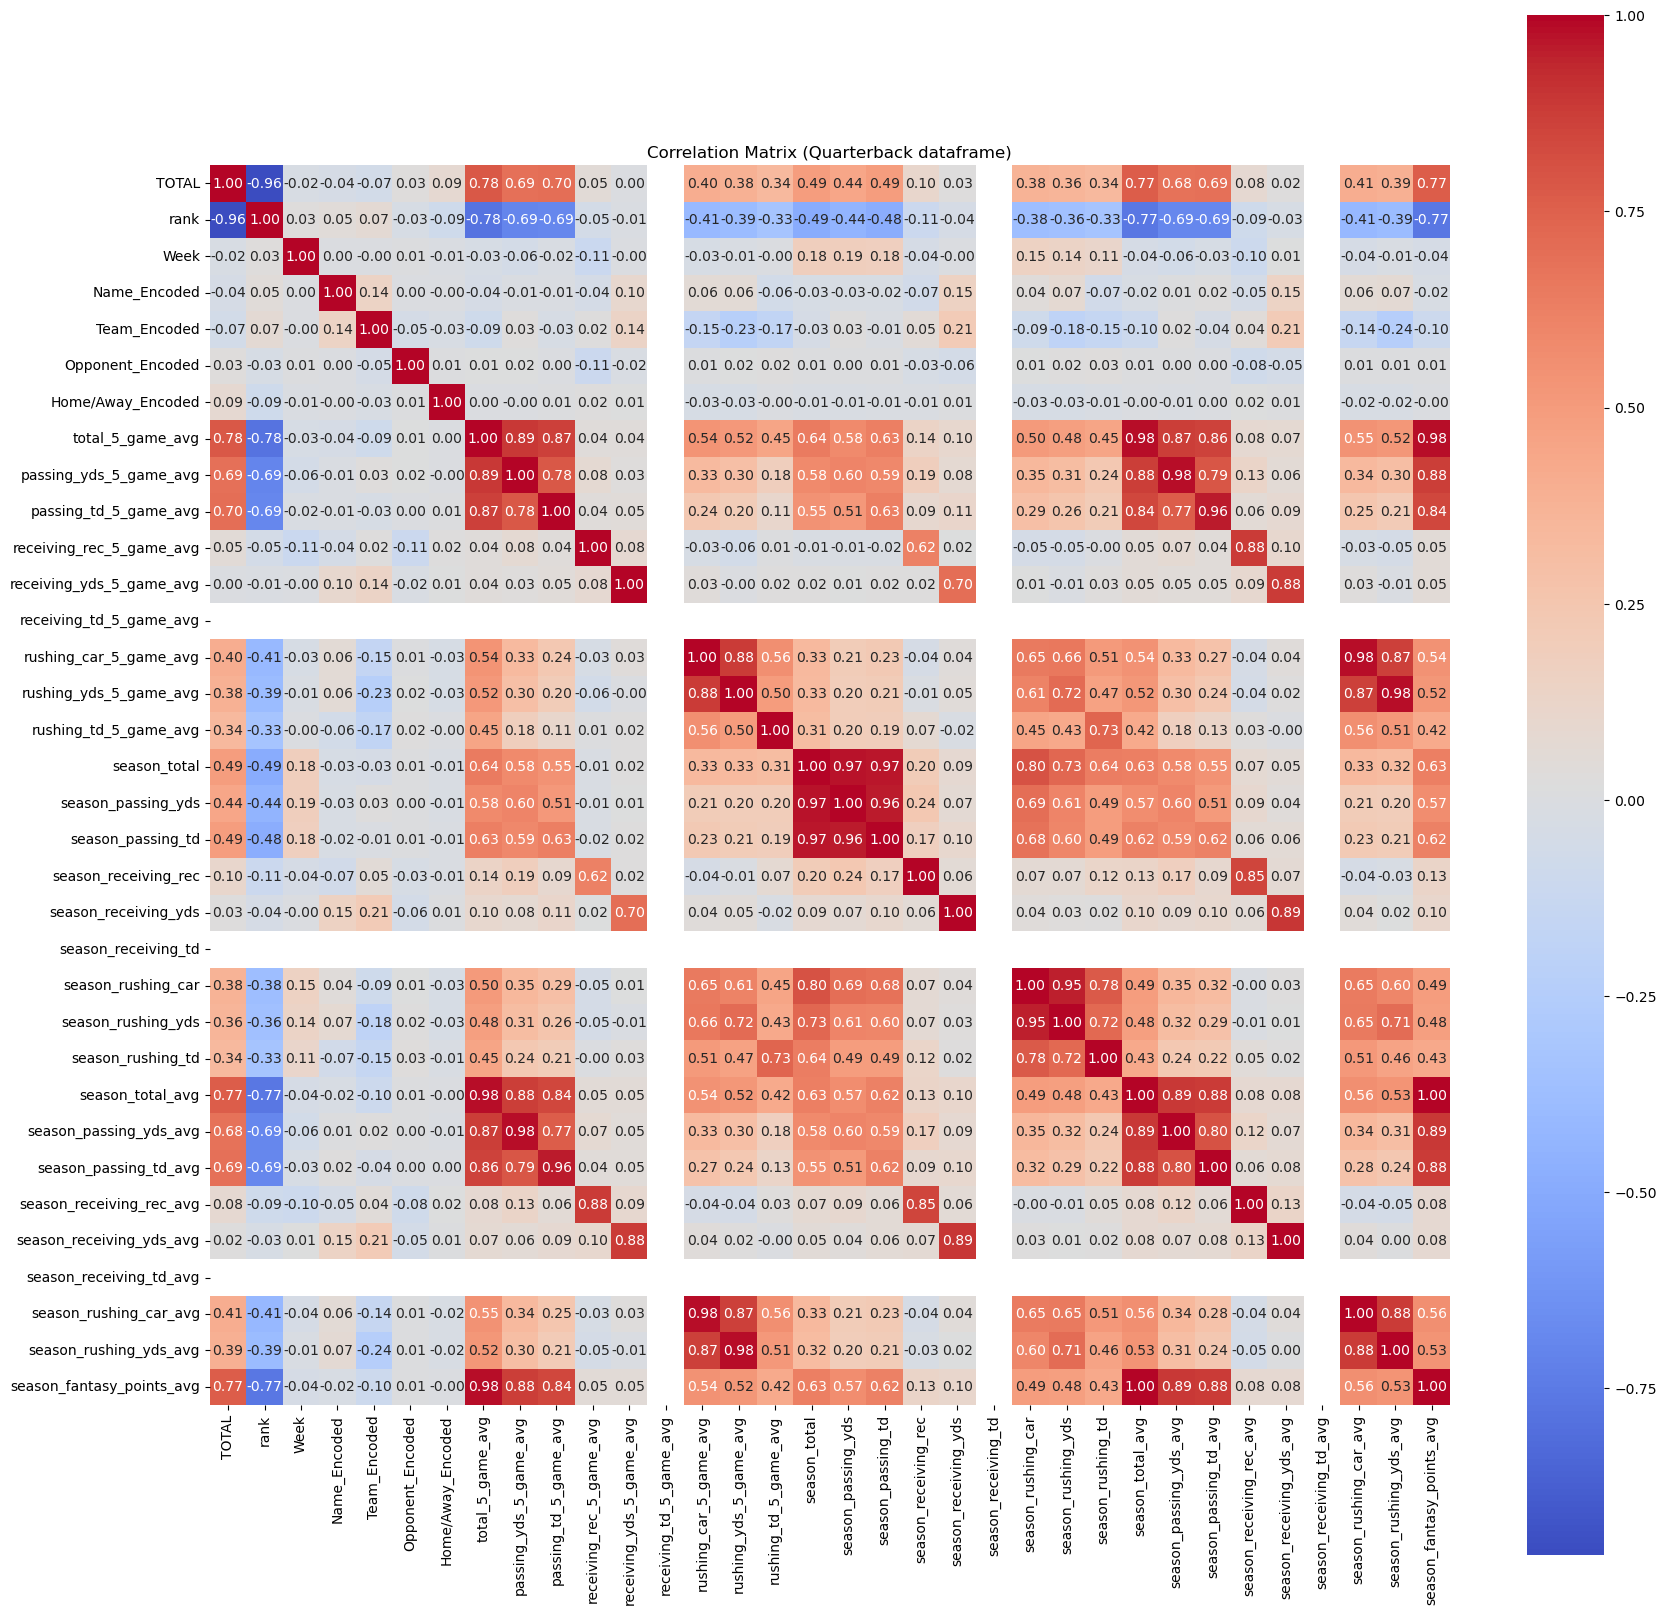

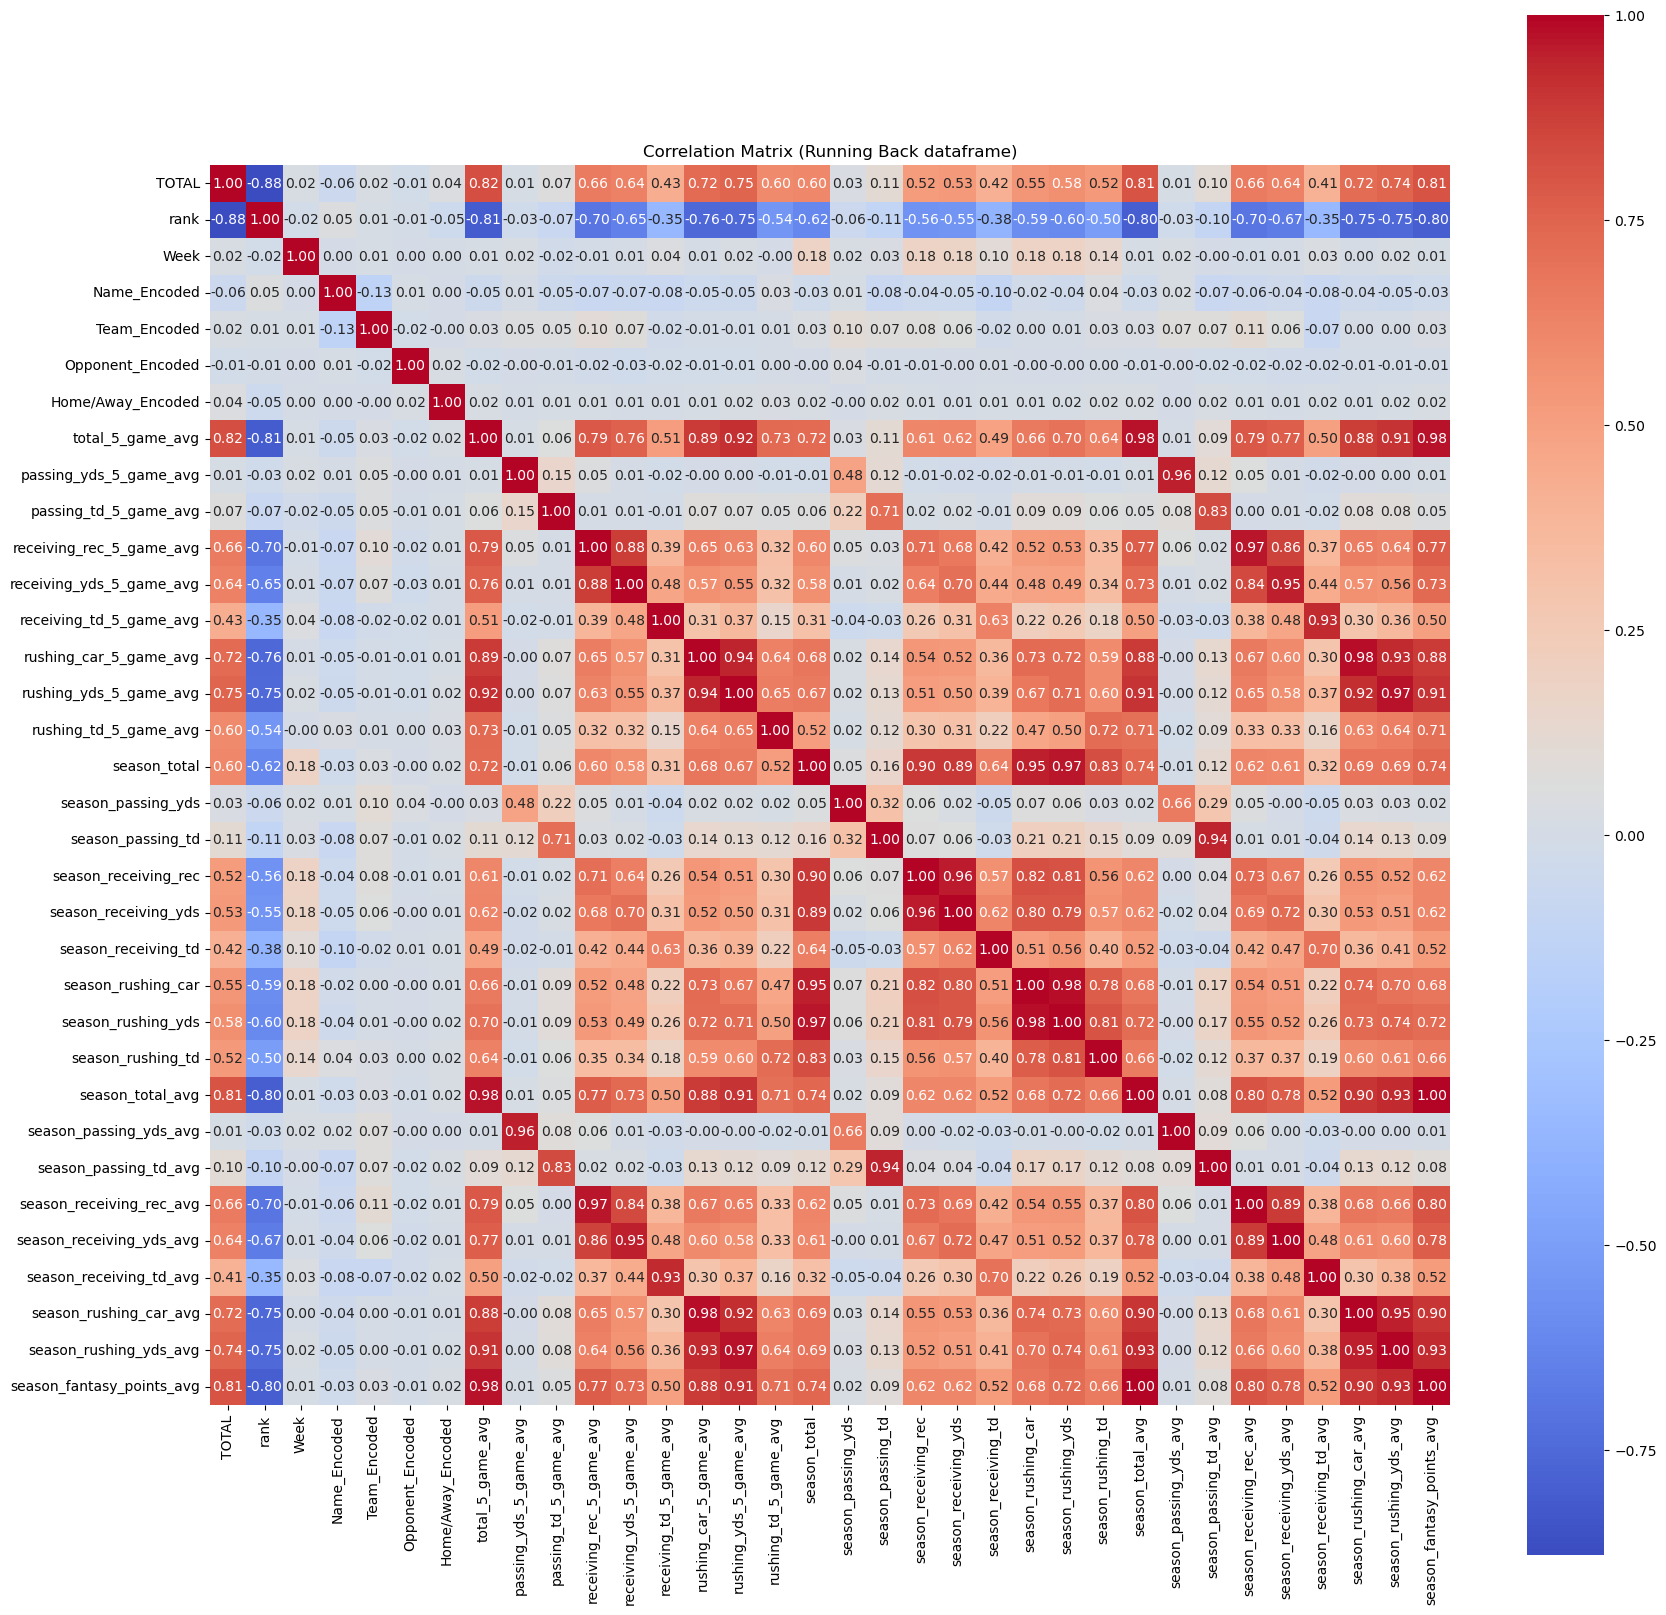

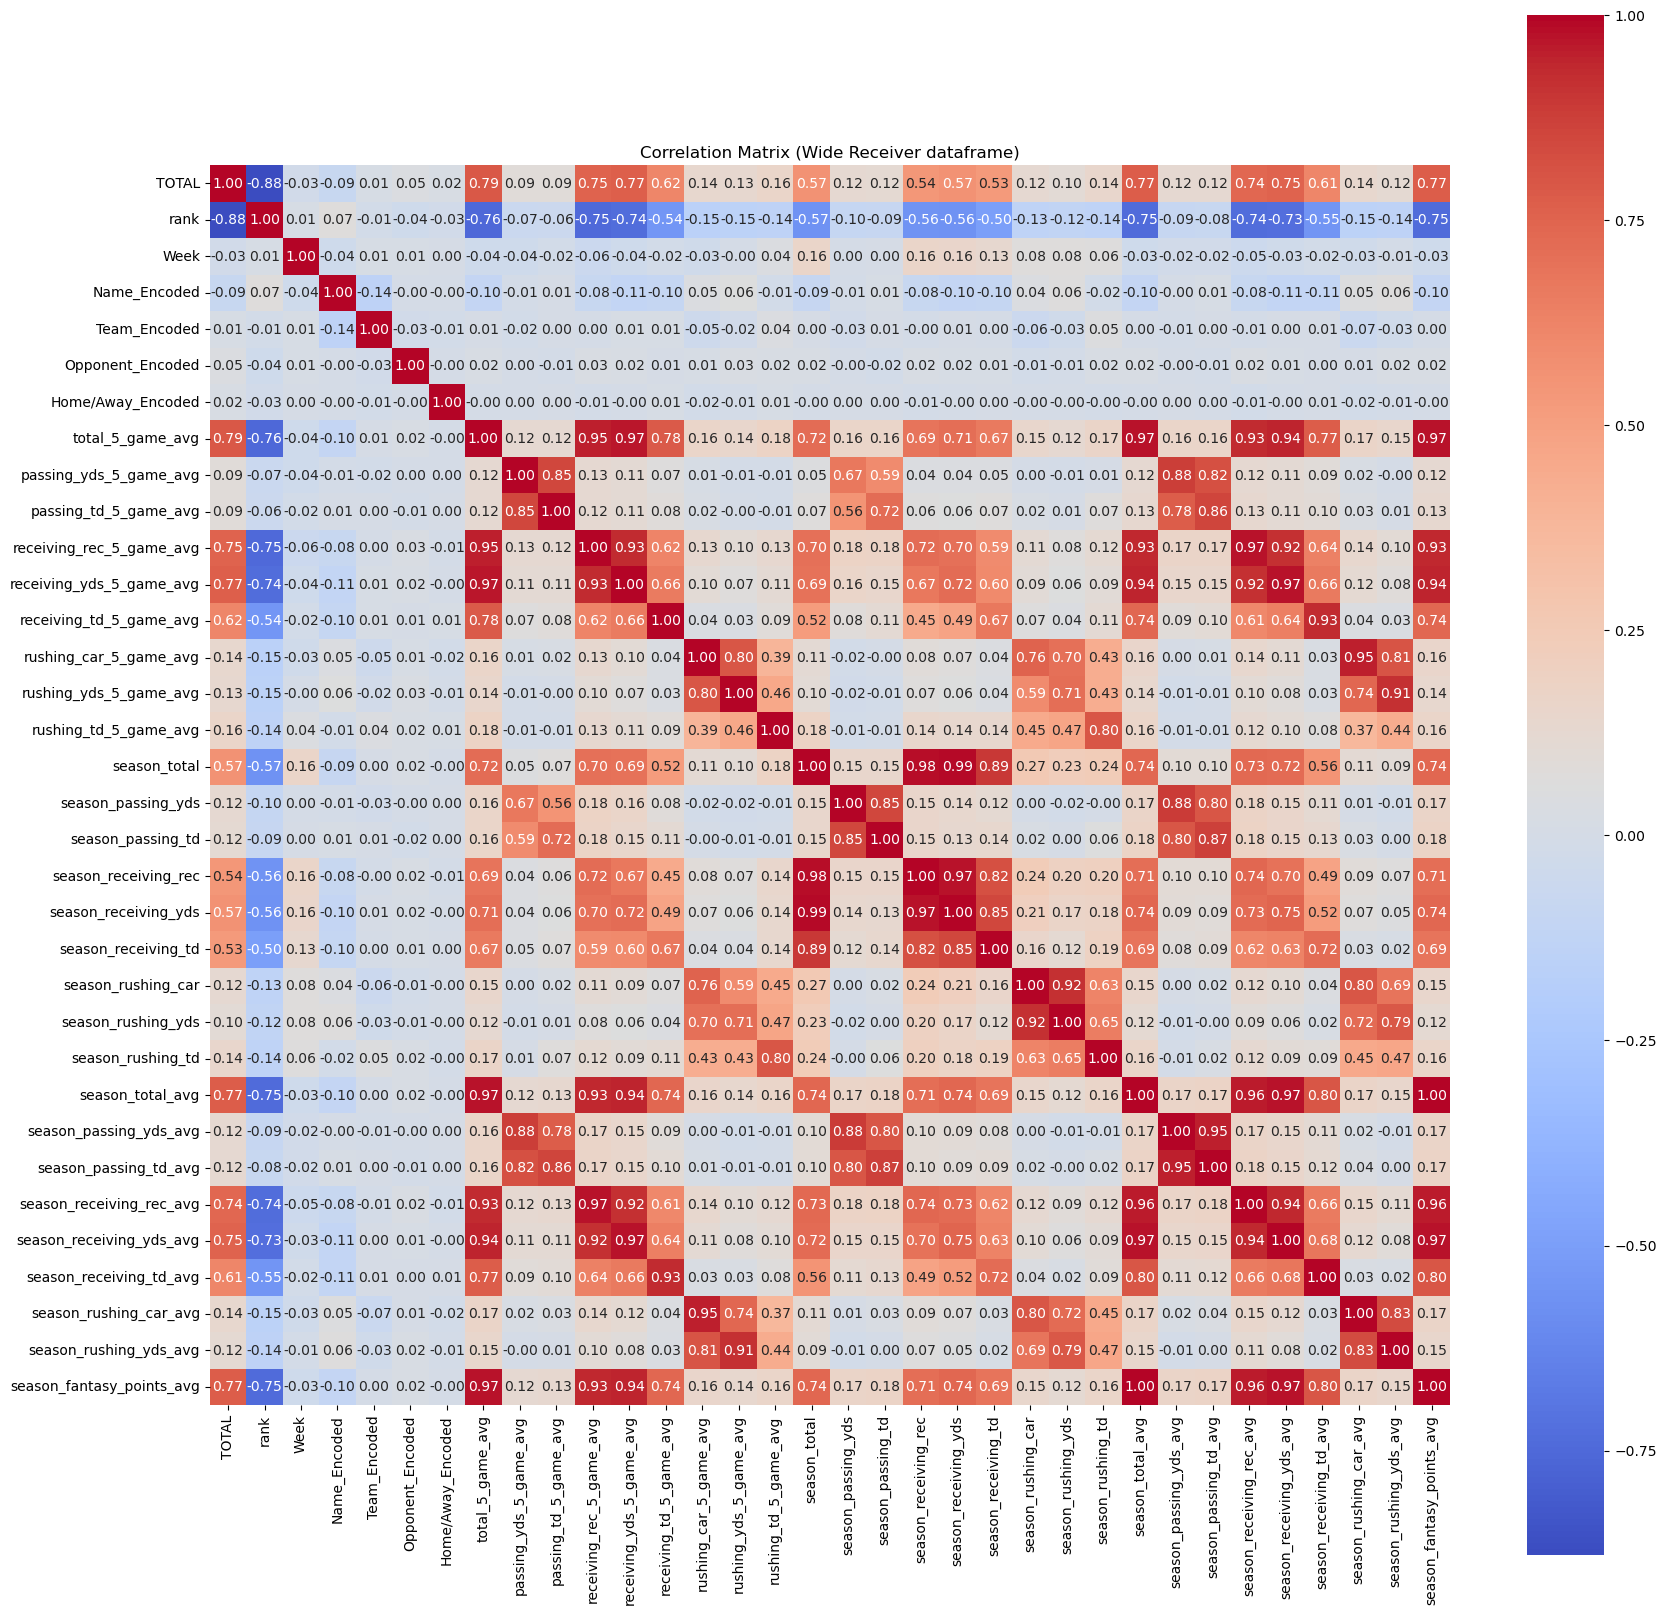

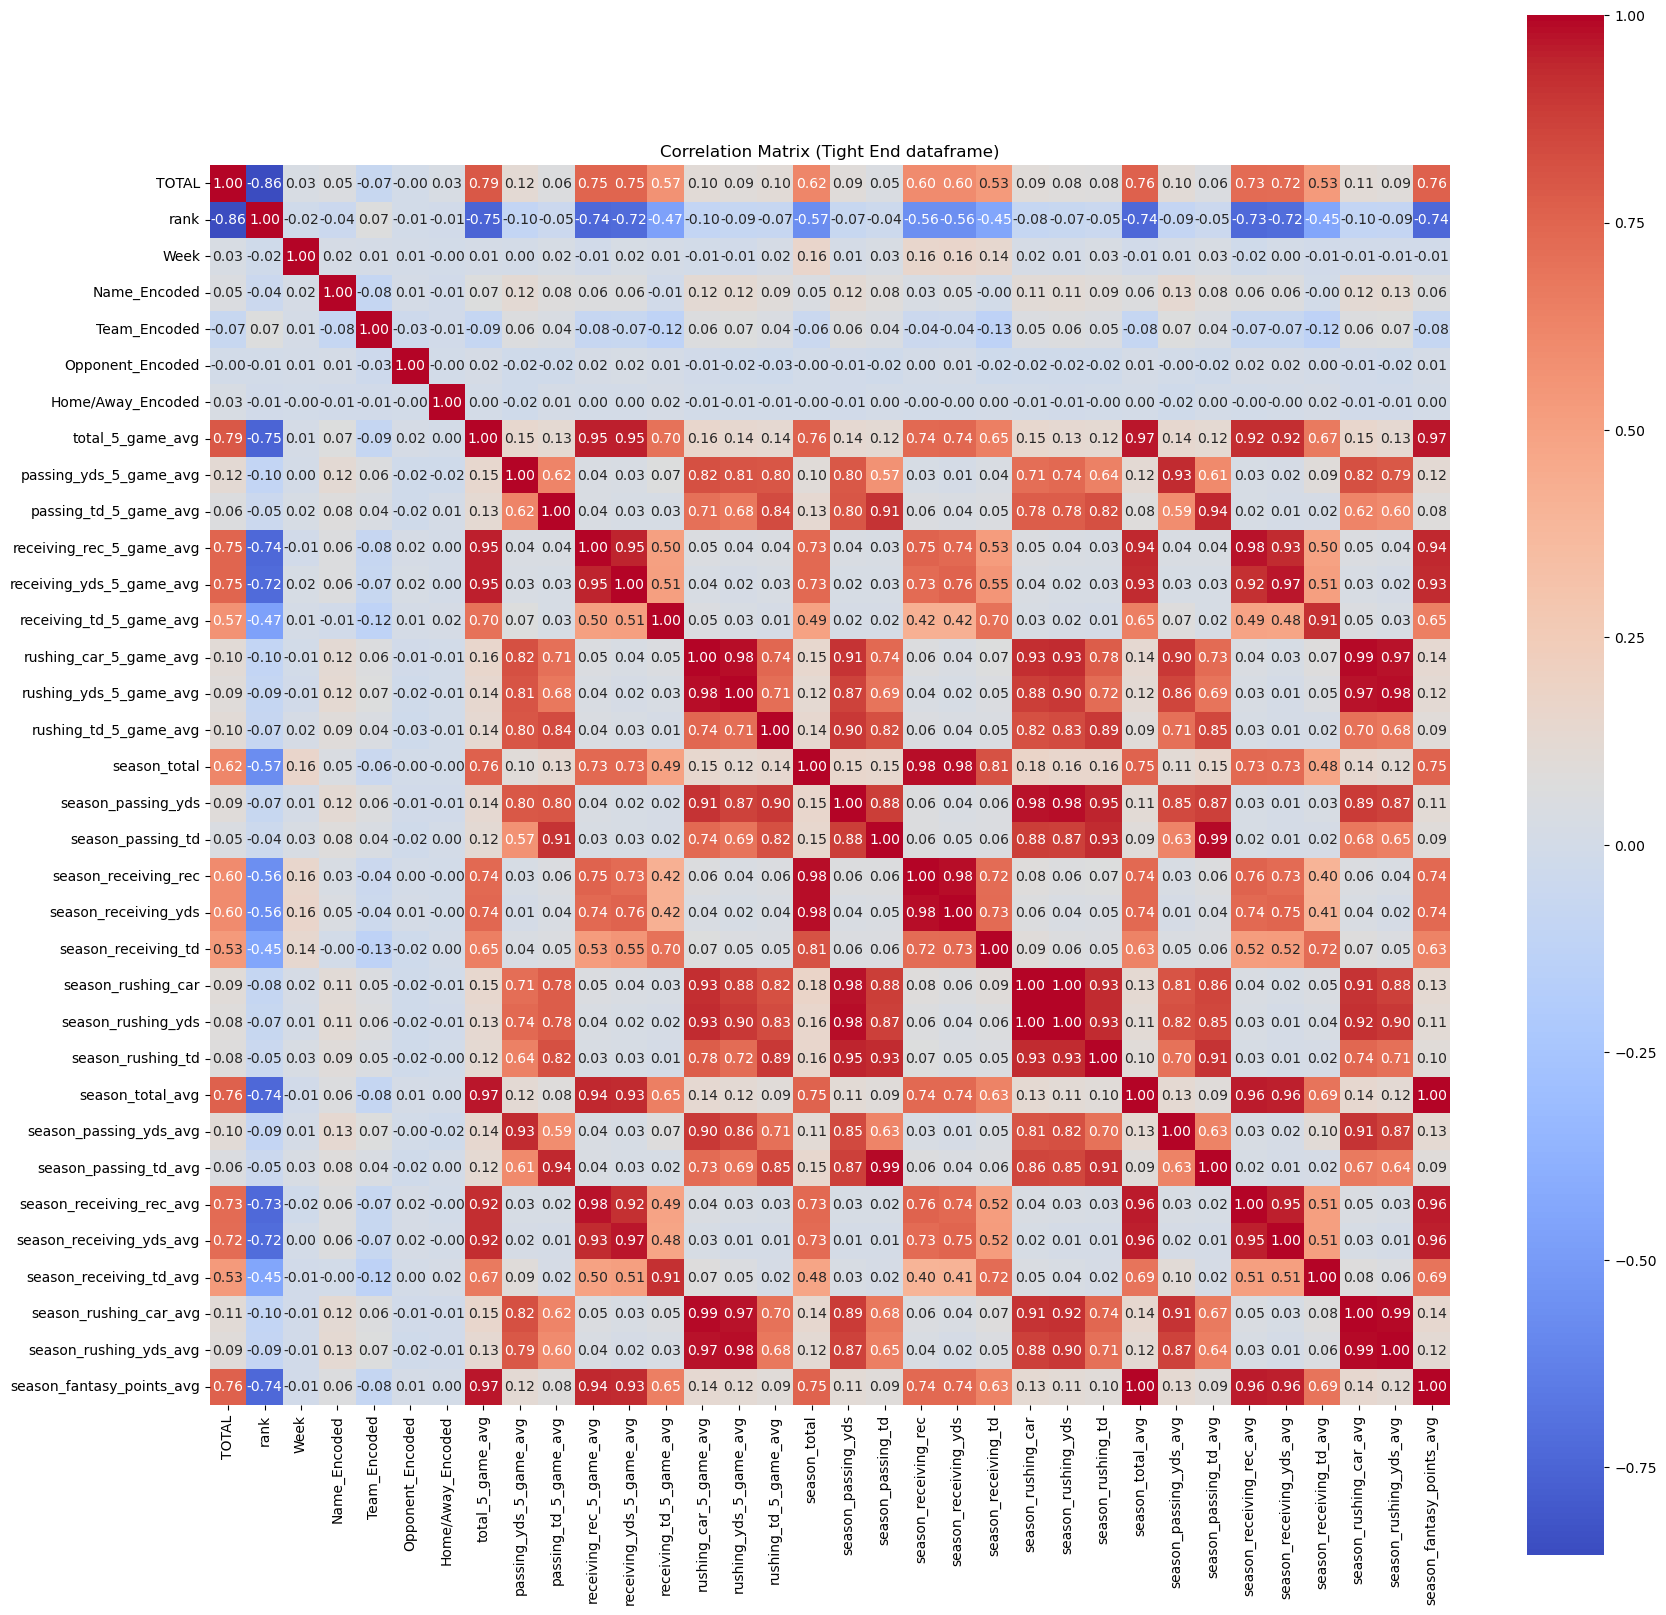

In [81]:
dfMList = { 'qbsM': qbsM, 'rbsM': rbsM, 'wrsM': wrsM, 'tesM': tesM}
#creating a dictionary that maps names to dataframes

dfNames = ['Quarterback', 'Running Back', 'Wide Receiver', 'Tight End']
#creating list for position names
#doing this allows me to use the position name for the title of each heatmap
#using 'name' within dfList would display 'qbsM dataframe'

for i, (name, dfM) in enumerate(dfMList.items()):
    dfC = dfM.select_dtypes(include='number').drop(columns=['did_not_play'])

    correlation_matrix = dfC.corr()

    plt.figure(figsize=(20, 20))
    plt.title(f'Correlation Matrix ({dfNames[i]} dataframe)')
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.show()

**Quarterbacks**
- Strong Positive Correlations with 'TOTAL':
    - fantasy_points_5_game_avg (0.88): The strongest positive correlation, indicating that recent fantasy points performance strongly impacts the total score
    - season_fantasy_points (0.66): Seasonal fantasy points also have a significant positive correlation
    - rushing_td_5_game_avg (0.64): Recent rushing touchdowns show a notable correlation with the target
    - receiving_yds_5_game_avg and rushing_yds_5_game_avg: Both show moderate-to-strong positive correlations
- Weaker Correlations:
    - Variables like Week, Home/Away_Encoded, and team-related features (e.g., Team_Encoded) have weak or negligible correlations with 'TOTAL'
- Negatively Correlated Variables:
    - Rank (-0.82): This is strongly negatively correlated, which makes sense since a higher rank typically indicates a lower numeric value (better performance)
    - Season vs. 5-game Averages: Seasonal stats (e.g., season_rushing_yds, season_receiving_yds) generally have lower correlations compared to the 5-game averages, suggesting recent performance trends are more predictive
- Collinear Features
    - Variables like season_fantasy_points, fantasy_points_5_game_avg, and rushing_td_5_game_avg are highly correlated with each other
    - Season_rushing_yds and season_rushing_tds are also strongly correlated with their respective 5-game averages
- Insights:
    - Focus on recent 5-game performance metrics (fantasy points, rushing/receiving stats) and the overall seasonal fantasy points as the strongest predictors for the 'TOTAL' variable
    - The 'rank' variable can also provide significant insight as it inversely correlates with 'TOTAL'

**Running Backs**
- Strong Positive Correlations with 'TOTAL':
    - fantasy_points_5_game_avg (0.88): Similar to the quarterback dataset, recent fantasy points are the strongest predictor of total performance
    - season_fantasy_points (0.77): Seasonal fantasy points also show a strong positive relationship with 'TOTAL'
    - receiving_yds_5_game_avg (0.77): Indicates the importance of recent receiving yards in predicting total performance
    - rushing_td_5_game_avg (0.75): Recent rushing touchdowns also contribute significantly to 'TOTAL.
- Weaker Correlations:
    - Team_Encoded, Home/Away_Encoded, and other encoded features have minimal correlations with the target
- Strong Negative Correlations: 
    - Rank (-0.88): Strong negative correlation, as expected, since better players (lower rank) contribute more to total performance
- Collinear Features: 
    - Variables like fantasy_points_5_game_avg, receiving_yds_5_game_avg, and rushing_td_5_game_avg are highly correlated with one another
    - Seasonal metrics (e.g., season_receiving_yds, season_rushing_yds) are also intercorrelated
- Insights:
    - The recent 5-game averages for fantasy points, receiving yards, and rushing touchdowns are the most predictive features for 'TOTAL'
    - Seasonal statistics provide additional context but have lower direct correlations

**Wide Receivers**
- Strong Positive Correlations with 'TOTAL':
    - fantasy_points_5_game_avg (0.86): Recent fantasy points performance is the strongest predictor of total performance
    - season_fantasy_points (0.75): Seasonal fantasy points have a strong positive relationship with 'TOTAL'
    - receiving_yds_5_game_avg (0.75): Highlights the importance of recent receiving yards in predicting performance
    - receiving_td_5_game_avg (0.47): Recent receiving touchdowns also contribute significantly to 'TOTAL'
- Weaker Correlations:
    - Features like Team_Encoded and Home/Away_Encoded have minimal or negligible correlations with 'TOTAL'
    - Variables like Week and Opponent_Encoded also have weak correlations
- Strong Negative Correlations:
    - Rank (-0.86): A strong negative correlation exists, meaning players with a lower rank (better performance) tend to contribute more to the 'TOTAL'
- Collinear Features:
    - fantasy_points_5_game_avg, receiving_yds_5_game_avg, and season_fantasy_points are highly correlated with each other, which could introduce multicollinearity
    - Seasonal stats like season_receiving_yds and season_receiving_rec are strongly correlated with their respective 5-game averages
- Insights:
    - Similar to quarterbacks and running backs, recent 5-game averages for fantasy points and receiving yards are the most predictive features for 'TOTAL'
    - Seasonal metrics are less predictive but provide complementary context

**Tight Ends**
- Strong Positive Correlations with 'TOTAL':
    - fantasy_points_5_game_avg (0.86): Recent fantasy points remain the strongest predictor of total performance.
    - season_fantasy_points (0.75): Seasonal fantasy points show a strong positive relationship with 'TOTAL.'
    - receiving_yds_5_game_avg (0.75): Highlights the importance of recent receiving yards for tight ends.
    - receiving_td_5_game_avg (0.47): Recent receiving touchdowns also contribute significantly to 'TOTAL.'
- Weaker Correlations:
    - Features like Team_Encoded, Opponent_Encoded, and Home/Away_Encoded have minimal or negligible correlations with 'TOTAL.'
    - Variables like Week and Name_Encoded also exhibit weak correlations.
- Strong Negative Correlations:
    - Rank (-0.86): A strong negative correlation indicates that lower rank (better players) corresponds with higher total performance.
- Collinear Features:
    - fantasy_points_5_game_avg, season_fantasy_points, and receiving_yds_5_game_avg are highly correlated with each other, pointing to potential multicollinearity.
    - Seasonal metrics (e.g., season_receiving_yds, season_receiving_rec) are strongly correlated with their respective 5-game averages.
- Insights:
    - Recent 5-game averages for fantasy points, receiving yards, and receiving touchdowns are the most predictive features for tight ends' 'TOTAL'
    - Seasonal statistics provide additional context but are less directly correlated

**Next Steps:**

Using PCA to deal with correlated features
- PCA is a technique used to transform the feature space into linear combinations of the original features, these components capture the most variance in the data while eliminating redundancy
- By projecting the data into a lower-dimensional space, PCA removes correlations between features

Using Ridge Regression to regularize
- Ridge regression is a linear regression model that adds an L2 penalty (squared magnitude of coefficients) to the loss function
- This shrinks the coefficients of less important features

**Model Architecture**
- 

- Preprocessing Stage:
    - Imputation (SimpleImputer): Handles missing values in the dataset, using (mean, median, etc.) in the paramGrid
    - Normalization (StandardScaler): Scales features to have a mean of 0 and standard deviation of 1, ensuring all features contribute equally to the model
- Dimensionality Reduction:
    - PCA (reduce_dim): As mentioned previously, reduces the feature space by transforming features into uncorrelated components that explain most of the variance
    - The number of components to retain is tunable
- Regression Model:
    - Ridge Regression (ridge): A linear regression model with L2 regularization that penalizes large coefficients, stabilizing the model in the presence of multicollinear features
    - Key hyperparameters like regularization strength (alpha) and solver type are tunable
- Pipeline Integration:
    - Steps: imputation > normalization > PCA > Ridge regression
    - The pipeline ensures that preprocessing, dimensionality reduction, and modeling are combined cohesively
- Hyperparameter Optimization (paramGrid):
    - Using a grid search that explores different configurations for imputation strategies, PCA components, Ridge parameters, and solvers to optimize performance

**Baseline Ridge Regression (QB)**
- 

Building a ridge regression model to predict fantasy points for quarterbacks, as a baseline model

Using ridge because almost all features are expected to contribute to 'Total', and also to reduce the risk of overfitting

**Model Pipeline**

In [74]:
estimators = [('imputer', SimpleImputer()),
              ('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('ridge', Ridge(alpha = 1.0))]

pipe = Pipeline(estimators)

paramGrid = {'imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
             'reduce_dim__n_components': [0.99, 0.95, 0.90, 0.85],
             'ridge__alpha': [0.01, 0.1, 1, 10, 100],
             'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             'ridge__fit_intercept': [True, False]}

**Building Model Pipeline**
- Model pipelines allow for the repeated use of the same workflow, including preprocessing and modeling steps, and allow for hyperparameter optimization through grid search with cross-validation 

- Estimators
    - SimpleImputer():
        - Handles missing values in the dataset by replacing them with specified strategies such as mean, median, or most frequent values
    - StandardScaler():
        - Standardizes the features by removing the mean and scaling to unit variance, ensuring that features have the same scale, which is important for PCA and Ridge Regression
    - PCA():
        - Performs Principal Component Analysis to reduce the dimensionality of the dataset while retaining as much variance as possible
    - Ridge():
        - Applies Ridge Regression, a linear regression technique with L2 regularization, which helps prevent overfitting by penalizing large coefficients
- Parameter Grid
    - imputer__strategy:
        - Strategy for imputing missing values
        - Options: 'mean', 'median', 'most_frequent', 'constant'
    - Reduce_dim__n_components:
        - Determines the number of principal components to keep in PCA, expressed as the fraction of variance to retain
            - For example, 0.99 means 99% of variance would be retained
        - Options: 0.99, 0.95, 0.90, 0.85
    - ridge__alpha:
        - Controls the strength of Ridge regularization:
            - Smaller values make the model less regularized, relying more on the data
            - Larger values increase regularization, penalizing large coefficients more heavily
        - Options: 0.01, 0.1, 1, 10, 100
    - ridge__solver:
        - Specifies the algorithm used to solve Ridge regression:
        - Options: 'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag' and 'saga'
    - ridge__fit_intercept:
        - Indicates whether to include the intercept in the Ridge model:
        - Options: True, False

**1st Iteration (Not Using Pipeline/Grid Search Cross Validation)**

In [75]:
Xqb = qbsM.select_dtypes(include = 'number').drop(columns=['TOTAL'])

yqb = qbsM['TOTAL']
#assigning X and Y

- Assigning X and y

In [76]:
Xqb_train, Xqb_test, yqb_train, yqb_test = train_test_split(Xqb, yqb, test_size = .20, random_state = 14)
#train, test, split

scaler = StandardScaler()
Xqb_train_scaled = scaler.fit_transform(Xqb_train)
Xqb_test_scaled = scaler.fit_transform(Xqb_test)
#scaling the features using standard scaler

qbRidge = Ridge(alpha = 1.0)
#instatiating the model

qbRidge.fit(Xqb_train_scaled, yqb_train)
#fitting the model to the training data

yqb_pred = qbRidge.predict(Xqb_test_scaled)
#getting predictions on the test set

mse = mean_squared_error(yqb_test, yqb_pred)
r2 = r2_score(yqb_test, yqb_pred)
#getting metrics to evaluate the model

print(f'R-squared: {r2}')
print(f'Mean squared error: {mse}')
#printing metrics

R-squared: 0.9033946155014341
Mean squared error: 8.87184841879569


- Building the quarterback ridge regression model manually
- R-squared
    - Solid value
    - The r-squared value was 0.9034, meaning 90.34% of the variance in the data is explained by the model
    - This is a very good starting point
- Mean squared error
    - Very poor value
    - The mean squared error was 8.87, meaning that the models predictions deviate from the actual values by 7.9
    - Being that most fantasy scores ranging from ~5-30, this is a very poor starting point

**2nd Iteration (Using Pipeline/Grid Search Cross Validation)**

In [77]:
Xqb_train, Xqb_test, yqb_train, yqb_test = train_test_split(Xqb, yqb, test_size = .20, random_state = 14)
#train, test, split

grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(Xqb_train, yqb_train)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
qbRidge = grid_search.best_estimator_
#setting best estimator to 'qbRidge'

yqb_pred = qbRidge.predict(Xqb_test)
r2 = r2_score(yqb_test, yqb_pred)
print("R-squared:", r2)
mae = mean_absolute_error(yqb_test, yqb_pred)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'constant', 'reduce_dim__n_components': 0.99, 'ridge__alpha': 0.1, 'ridge__fit_intercept': True, 'ridge__solver': 'saga'}
R-squared: 0.9127460334688716
Mean Absolute Error (MAE): 2.0486112053100376


- Train test splitting
    - Using 20% test size
- Creating and fitting model
- Performing grid search
    - Optimal parameters
        - 'imputer__strategy': 'mean'
        - 'reduce_dim__n_components': 0.99
        - 'ridge__alpha': 1
        - 'ridge__fit_intercept': True
        - 'ridge__solver': 'sparse_cg'
- R-squared
    - 91.27% of the variance in the data is explained by the model
    - Very slight improvement since the first iteration
    - Grid search cross validation made very little change
        - This is likely since the initial model was already explaining most of the variance in the data, optimizing hyperparameters won't drastically improve R-squared
        - It may only fine-tune the model's predictions slightly
- Mean Absolute Error
    - On average, the model’s predictions of NFL fantasy points deviate from the actual values by ~2 points
    - This is a huge improvement in comparison to the first iteration, and is a good value for a baseline model
    - It is evident that the grid search greatly improved the model in this regard
        - The grid search identified a more optimal parameter or preprocessing step that reduced large outliers in the predictions

**Baseline Ridge Regression (RB)**
- 

Building a ridge regression model using a top-down approach to predict fantasy points for running backs, as a baseline model

Using ridge because almost all features are expected to contribute to 'Total', and also to reduce the risk of overfitting

In [23]:
rbsM.head(2)

,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,TOTAL,Opponent,Location,rank,DATE,Week,...,season_rushing_car,season_rushing_yds,season_rushing_tds,season_fantasy_points_avg,season_receiving_rec_avg,season_receiving_yards_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_rushing_tds_avg
1264,AJ Dillon,GB,RB,W 33-10,2.7,Min,Away,65.0,01-02-24,17,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
149,AJ Dillon,GB,RB,W 38-20,5.6,Chi,Away,42.0,09-12-23,1,...,7.0,27.0,0.0,1.35,0.0,0.0,0.0,3.5,13.5,0.0


In [79]:
Xrb = rbsM.select_dtypes(include = 'number').drop(columns=['TOTAL'])

yrb = rbsM['TOTAL']
#assigning X and Y

**1st Iteration (Not Using Pipeline/Grid Search Cross Validation)**

In [92]:
Xrb_train, Xrb_test, yrb_train, yrb_test = train_test_split(Xrb, yrb, test_size = .20, random_state = 14)
#train, test, split

scaler = StandardScaler()
Xrb_train_scaled = scaler.fit_transform(Xrb_train)
Xrb_test_scaled = scaler.fit_transform(Xrb_test)
#scaling the features using standard scaler

rbRidge = Ridge(alpha = 1.0)
#instatiating the model

rbRidge.fit(Xrb_train_scaled, yrb_train)
#fitting the model to the training data

yrb_pred = rbRidge.predict(Xrb_test_scaled)
#getting predictions on the test set

mse = mean_squared_error(yrb_test, yrb_pred)
r2 = r2_score(yrb_test, yrb_pred)
#getting metrics to evaluate the model

print(f'R-squared: {r2}')
print(f'Mean squared error: {mse}')
#printing metrics

R-squared: 0.7966266071270506
Mean squared error: 11.598110826863406


- Building the running back ridge regression model manually
- R-squared
    - Moderate value
    - The r-squared value was 0.7966, meaning 79.66% of the variance in the data is explained by the model
    - This is a very good starting point
- Mean squared error
    - Very poor value
    - The mean squared error was 11.56, meaning that on average the models predictions deviate from the actual values by 10.82
    - This is a very poor starting point

**2nd Iteration (Using Pipeline/Grid Search Cross Validation)**

In [93]:
X_train, X_test, y_train, y_test = train_test_split(Xrb, yrb, test_size = .20, random_state = 14)
#train, test, split

grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_train, y_train)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
rbRidge = grid_search.best_estimator_
#setting best estimator to 'rbRidge'

y_pred = rbRidge.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'most_frequent', 'reduce_dim__n_components': 0.99, 'ridge__alpha': 10, 'ridge__fit_intercept': True, 'ridge__solver': 'sag'}
R-squared: 0.797148227336608
Mean Absolute Error (MAE): 2.365566227393895


- Building the model using the model pipeline and grid search cross validation
- R-Squared
    - ~80% of the variance is accounted for by the model
- Mean Absolute Error
    - Huge improvement since the first iteration
    - The predictions now deviate from the actual values by ~2.3 points on average as opposed to ~11.5
    - It is evident that the grid search cross validation has greatly improved the model

**3rd Iteration (Using Pipeline/Grid Search Cross Validation)**

After receiving somewhat moderate metrics, this iteration features that have very little correlation with the target variable ('TOTAL'), or are strongly correlate with others will be removed. For example, season_receiving_yds and receiving_yds_5_game_avg are highly correlated, so I will be removing receiving_yds_5_game_avg because it is slightly less correlated to the target variable. I will not be removing all collinear columns, however, because variables like season_rushing_yds and rushing_yds_5_game_avg are highly correlated, but are an essential factor in predicting runningback performance. When features are highly correlated with each other, it can lead to multicollinearity, which can make it difficult to determine which feature contributes more to the prediction. This is especially an issue when using linear models.

In [25]:
Xrb2 = rbsM.select_dtypes(include = 'number').drop(columns=['TOTAL', 'receiving_rec_5_game_avg', 'season_receiving_rec', 'Team_Encoded', 'Opponent_Encoded', 'Home/Away_Encoded', 'Week'])
#dropping columns from the list of independent variables

- Dropping columns 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(Xrb2, yrb, test_size = .20, random_state = 14)
#train, test, split

grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_train, y_train)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
rbRidge= grid_search.best_estimator_
#setting best estimator to 'rbRidge'

y_pred = rbRidge.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'mean', 'reduce_dim__n_components': 0.99, 'ridge__alpha': 10, 'ridge__fit_intercept': True, 'ridge__solver': 'lsqr'}
R-squared: 0.8121788853633773
Mean Absolute Error (MAE): 2.2419486892540226


- Metrics essentially remained the same
    - R-squared value changed 0.0023%
    - The mean absolute error changed by 0.039
- It is fair to say that removing these features was not the right approach
- Further model tuning will be explored in the subsequent notebook

**Baseline Ridge Regression (WR)**
- 

Building a ridge regression model using a top-down approach to predict fantasy points for Wide Receivers, as a baseline model

Using ridge because almost all features are expected to contribute to 'Total', and also to reduce the risk of overfitting

In [94]:
wrsM.head(2) 

,PLAYER NAME,PLAYER TEAM,PLAYER POSITION,STATUS,TOTAL,Opponent,Location,rank,DATE,Week,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
1912,A.J. Brown,Phi,WR,L 31-35,9.3,Ari,Home,45.0,01-02-24,17,...,0.0,9.3,0.0,0.0,4.0,53.0,0.0,0.0,0.0,9.3
1384,A.J. Brown,Phi,WR,L 10-27,-0.1,NYG,Away,163.0,01-09-24,18,...,0.0,4.6,0.0,0.0,2.5,31.0,0.0,0.0,0.0,4.6


In [95]:
Xwr = wrsM.select_dtypes(include = 'number').drop(columns=['TOTAL'])
ywr = wrsM['TOTAL']
#assigning X and Y

- Assigning X and Y

In [96]:
Xwr.head(2)

,rank,Week,did_not_play,Name_Encoded,Team_Encoded,Opponent_Encoded,Home/Away_Encoded,total_5_game_avg,passing_yds_5_game_avg,passing_td_5_game_avg,...,season_rushing_td,season_total_avg,season_passing_yds_avg,season_passing_td_avg,season_receiving_rec_avg,season_receiving_yds_avg,season_receiving_td_avg,season_rushing_car_avg,season_rushing_yds_avg,season_fantasy_points_avg
1912,45.0,17,0,0,25,0,1,9.3,0.0,0.0,...,0.0,9.3,0.0,0.0,4.0,53.0,0.0,0.0,0.0,9.3
1384,163.0,18,0,0,25,23,0,4.6,0.0,0.0,...,0.0,4.6,0.0,0.0,2.5,31.0,0.0,0.0,0.0,4.6


**1st Iteration (Not Using Pipeline/Grid Search Cross Validation)**

In [97]:
Xwr_train, Xwr_test, ywr_train, ywr_test = train_test_split(Xwr, ywr, test_size = .20, random_state = 14)
#train, test, split

scaler = StandardScaler()
Xwr_train_scaled = scaler.fit_transform(Xwr_train)
Xwr_test_scaled = scaler.fit_transform(Xwr_test)
#scaling the features using standard scaler

wrRidge = Ridge(alpha = 1.0)
#instatiating the model

wrRidge.fit(Xwr_train_scaled, ywr_train)
#fitting the model to the training data

ywr_pred = wrRidge.predict(Xwr_test_scaled)
#getting predictions on the test set

mse = mean_squared_error(ywr_test, ywr_pred)
r2 = r2_score(ywr_test, ywr_pred)
#getting metrics to evaluate the model

print(f'R-squared: {r2}')
print(f'Mean squared error: {mse}')
#printing metrics

R-squared: 0.8243752017312804
Mean squared error: 10.65019923794245


- Building the wide receiver ridge regression model manually
- R-squared
    - Moderate value
    - The r-squared value was 0.8243, meaning 82.43% of the variance in the data is explained by the model
    - This is a good starting point
- Mean squared error
    - Very poor value
    - The mean squared error was 10.65, meaning that on average the models predictions deviate from the actual values by 10.65
    - This is a very poor starting point

**2nd Iteration (Using Pipeline/Grid Search Cross Validation)**

In [98]:
X_trainwr, X_testwr, y_trainwr, y_testwr = train_test_split(Xwr, ywr, test_size = .20, random_state = 14)
#train, test, split

grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainwr, y_trainwr)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
wrRidge = grid_search.best_estimator_
#setting best estimator to 'wrRidge'

y_predwr = wrRidge.predict(X_testwr)
r2 = r2_score(y_testwr, y_predwr)
print("R-squared:", r2)
mae = mean_absolute_error(y_testwr, y_predwr)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'mean', 'reduce_dim__n_components': 0.99, 'ridge__alpha': 10, 'ridge__fit_intercept': True, 'ridge__solver': 'lsqr'}
R-squared: 0.828693575427371
Mean Absolute Error (MAE): 2.28957782609391


- Building the model using the model pipeline and grid search cross validation
- R-Squared
    - ~82% of the variance is accounted for by the model
    - Essentially the same
- Mean Absolute Error
    - Huge improvement since the first iteration
    - The predictions now deviate from the actual values by ~2.2 points on average as opposed to ~10.6
    - It is evident that the grid search cross validation has greatly improved the model

**Baseline Ridge Regression (TE)**
- 

Building a ridge regression model using a top-down approach to predict fantasy points for tight ends, as a baseline model

Using ridge because almost all features are expected to contribute to 'Total', and also to reduce the risk of overfitting

In [99]:
Xte = tesM.select_dtypes(include = 'number').drop(columns=['TOTAL'])

yte = tesM['TOTAL']
#assigning X and Y

**1nd Iteration (Not Using Pipeline/Grid Search Cross Validation)**

In [100]:
X_trainte, X_testte, y_trainte, y_testte = train_test_split(Xte, yte, test_size = .20, random_state = 14)
#train, test, split

scaler = StandardScaler()
Xte_train_scaled = scaler.fit_transform(X_trainte)
Xte_test_scaled = scaler.fit_transform(X_testte)
#scaling the features using standard scaler

teRidge = Ridge(alpha = 1.0)
#instatiating the model

teRidge.fit(Xte_train_scaled, y_trainte)
#fitting the model to the training data

yte_pred = teRidge.predict(Xte_test_scaled)
#getting predictions on the test set

mse = mean_squared_error(y_testte, yte_pred)
r2 = r2_score(y_testte, yte_pred)
#getting metrics to evaluate the model

print(f'R-squared: {r2}')
print(f'Mean squared error: {mse}')
#printing metrics

R-squared: 0.626182906343876
Mean squared error: 11.20028765577682


- Building the tight end ridge regression model manually
- R-squared
    - Moderate value
    - The r-squared value was 0.6262, meaning 62.62% of the variance in the data is explained by the model
    - This is a moderate starting point
- Mean squared error
    - Very poor value
    - The mean squared error was 11.2, meaning that on average the models predictions deviate from the actual values by 11.2
    - This is the best MSE we have seen so far when it comes to the manual iterations, however it is still not a great starting point

**2nd Iteration (Using Pipeline/Grid Search Cross Validation)**

In [101]:
X_trainte, X_testte, y_trainte, y_testte = train_test_split(Xte, yte, test_size = .20, random_state = 14)
#train, test, split

grid_search = GridSearchCV(pipe, paramGrid, cv=5, scoring='neg_mean_squared_error')
#performing grid search using 5 fold cross validation

grid_search.fit(X_trainte, y_trainte)
#fitting grid search

print("Best parameters:", grid_search.best_params_)
teRidge = grid_search.best_estimator_
#setting best estimator to 'teRidge'

y_predte = teRidge.predict(X_testte)
r2 = r2_score(y_testte, y_predte)
print("R-squared:", r2)
mae = mean_absolute_error(y_testte, y_predte)
print("Mean Absolute Error (MAE):", mae)
#printing best parameters, r-squared, and mean absolute error

Best parameters: {'imputer__strategy': 'constant', 'reduce_dim__n_components': 0.99, 'ridge__alpha': 10, 'ridge__fit_intercept': True, 'ridge__solver': 'sag'}
R-squared: 0.7530988120223914
Mean Absolute Error (MAE): 1.741808994519365


- Building the model using the model pipeline and grid search cross validation
- R-Squared
    - ~75.31% of the variance is accounted for by the model
    - Much better, increase of ~13%
- Mean Absolute Error
    - Huge improvement since the first iteration
    - The predictions now deviate from the actual values by ~1.7 points on average as opposed to ~11.2
    - Lowest MSE among each of the models
    - It is evident that the grid search cross validation has greatly improved the model

**Analyzing Evaluation Metrics**
- 

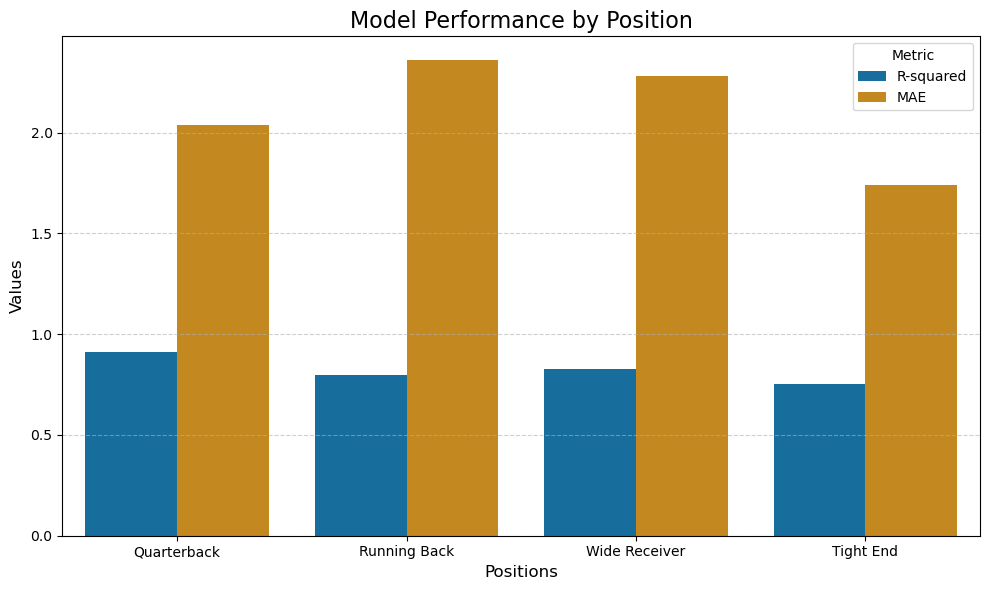

In [3]:
evalData = {
    'Position': ['Quarterback', 'Running Back', 'Wide Receiver', 'Tight End'],
    'R-squared': [0.912, 0.797, 0.828, 0.753],
    'MAE': [2.04, 2.36, 2.28, 1.74]
}
#creating dictionary wiht evaluation data

evaldf = pd.DataFrame(evalData)
#turning it into a dataframe

df_melted = evaldf.melt(id_vars='Position', var_name='Metric', value_name='Value')
#melting the dataframe to use seaborn

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Position', y='Value', hue='Metric', palette='colorblind')
plt.title('Model Performance by Position', fontsize=16)
plt.xlabel('Positions', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Metric', fontsize=10)
plt.tight_layout()
plt.show()
#plotting

R-squared Performance:
- Quarterbacks achieved the highest R-squared value (~0.912), indicating the model explains the most variance for this position
- Running Backs and Wide Receivers followed closely, with R-squared values around 0.797 and 0.828, respectively
- Tight Ends had the lowest R-squared (~0.753), suggesting the model struggles to capture variance in their performance

MAE Comparison:
- Tight Ends had the lowest Mean Absolute Error (MAE), around 1.74, indicating the model's predictions for this position were the most accurate on average
- Quarterbacks and Running Backs had similar MAE values (~2.04 and ~2.36), indicating slightly less accurate predictions compared to WRs and TEs

General Trends:
- The higher R-squared for Quarterbacks and Running Backs aligns with their consistent roles in contributing to fantasy points, driven by key metrics like receiving and rushing stats
- The lower R-squared for Tight Ends might be due to their less predictable usage patterns and smaller sample sizes

**Baseline Modeling Summary**
- 

**Key Steps:**
- Computed 5-game rolling averages for key stats (e.g., passing yards, rushing yards, receiving yards) to capture recent trends in player performance
- Calculated cumulative and average stats for fantasy points, rushing, passing, and receiving metrics up to each week, excluding the current week
- Implemented baseline regression models to predict player fantasy performance
- Used both cumulative season metrics and recent 5-game averages as predictors to evaluate their impact on predictive accuracy

**Model Evaluation:**
- Evaluated models using metrics like Mean Absolute Error (MAE) and R-squared to assess predictive power across each model
- Found that certain positions received better metrics likely due to differences in the nature of their roles, statistical contributions, and variability in performance
- The inclusion of grid search cross validation significantly improved predictions for each position

In [105]:
dfAll.to_csv("dfAll.csv")
qbsM.to_csv("qbsM.csv")
rbsM.to_csv("rbsM.csv")
wrsM.to_csv("wrsM.csv")
tesM.to_csv("tesM.csv")
#converting dataframes to csv

Exporting DataFrames